In this project itried to build a model for sentiment nalysis from the comments in twitter. i have taken the dataset and refrence from kaggle.

1)data pre-processing-
 removing stopwords
 stemmig of words
 tokenization

2)preparing and training w2v model  using gensim

3)rnn model
 keras sequential model is used.
 input length is 300
 model layers:
  input(embedding layer)
  dropout layer
  lstm layer for seq
  dense layer with sigmoid ouput 

4)training and evaluation-
 loss function-cross entropy 
 evaluation-accuracy
  
 

   


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [0]:
#scikit 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
#keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation,Dense,Dropout,Embedding,Flatten,Conv1D,MaxPooling1D,LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

Using TensorFlow backend.


In [0]:
#nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [0]:
#word to vec
import gensim

In [0]:
#utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools


In [0]:
#set log
logging.basicConfig(format='%(asctime)s :%(levelname)s :%(message)s',level=logging.INFO)

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
#dataset
DATASET_COLUMNS=["target","ids","date","flag","user","text"]
DATASET_ENCODING="ISO-8859-1"
TRAIN_SIZE=.75

#TEXT CLEANINIG
TEXT_CLEANING_RE="@\S+|https?:\S+|http?:\S\[^A-Za-z0-9]+"

#WORD_VECTOR

W2V_SIZE=300
W2V_WINDOW=7
W2V_EPOCH=25
W2V_MIN_COUNT=10

#KERAS
SEQUENCE_LENGTH=300
EPOCHS=1
BATCH_SIZE=500

#SENTIMENT
POSITIVE="POSITIVE"
NEGATIVE="NEGATIVE"
NEUTRAL="NEUTRAL"
SENTIMENT_THRESHOLDS=(.4,.8)

#EXPORT
KERAS_MODEL="model.h5"
WORD2VEC_MODEL="model.w2v"
TOKENIZER_MODEL="tokenizer.pkl"
ENCODER_MODEL="encoder.pkl"

In [0]:
#dataset detail
# target:polarity of the tweet(0=negative,2=neutral,4=positive)
# ids:the id of the tweet
# date:date of tweet
# flag:the query 
# user:twitter
# text:the text of tweet

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df=pd.read_csv("/content/drive/My Drive/database_folder/twitter_data/training.1600000.processed.noemoticon.csv",encoding=DATASET_ENCODING,names=DATASET_COLUMNS)
#column name are added into dataset
#encoding don't know why

In [13]:
print("Dataset size: ",len(df))

Dataset size:  1600000


In [15]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [0]:
#defining function to decode sentiments from number to word
decode={0:"NEGATIVE",2:"NEUTRAL",4:"POSITIVE"}

def decode_sent(num):
  return decode[int(num)]

In [0]:
#ignore this cell
ans=[]
for i in range(len(df)):
  t=df.target[i]
  ans.append(decode_sent(t))

ans[:10]

In [0]:
df.target=df.target.apply(lambda x:decode_sent(x))

Text(0.5, 1.0, 'dataset labels distribution')

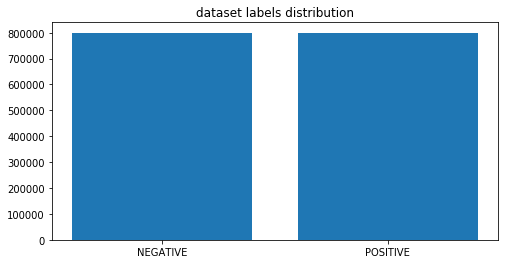

In [16]:
#plotting data
target_cnt=Counter(df.target)#counter make frequency table

plt.figure(figsize=(8,4))
plt.bar(target_cnt.keys(),target_cnt.values())
plt.title("dataset labels distribution")

In [0]:
#PRE_PROCESS DATASET

In [0]:
stop_words=stopwords.words("english")
stemmer=SnowballStemmer("english")

In [0]:

#text cleaning,removal of special chRACTER
#strip function to remove leading and trailing character(whitespaces here)
def preprocess(text,stem=False):
  text=re.sub(TEXT_CLEANING_RE,' ',str(text).lower()).strip()

#now tokenizing the clean text
  tokens=[]

  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)

  return " ".join(tokens)  




In [0]:
df.text=df.text.apply(lambda x:preprocess(x))

In [0]:
#split train and test

df_train,df_test=train_test_split(df,test_size=1-TRAIN_SIZE,random_state=42)

In [23]:
print("test_size: ",len(df_test))
print("train_size: ",len(df_train))


test_size:  400000
train_size:  1200000


In [0]:
#word 2 vec

In [0]:
documents=[_text.split() for _text in df_train.text]

In [25]:
documents[:5]

[['dame!!!1'],
 ['thesaurus', 'world', 'sale', 'ended'],
 ['ight', 'let', 'lil', 'white', 'boy', 'know.', 'hahaha.'],
 ['tweetlater', 'pro', 'way', 'go', 'really', 'want', 'work', 'them..like'],
 ['loved']]

In [0]:
#definig model for word 2 vec conversion
#here we have use Cbow for word embading
#after definig the model we will train it on our data for w2v represent
w2v_model=gensim.models.word2vec.Word2Vec(size=W2V_SIZE,window=W2V_WINDOW,min_count=W2V_MIN_COUNT,workers=8)

In [27]:
#this is to make vocabulary of words from our data
# for easy of word prediction this vocab will be used
w2v_model.build_vocab(documents)

2019-12-16 05:23:55,995 :INFO :collecting all words and their counts
2019-12-16 05:23:55,997 :INFO :PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-16 05:23:56,030 :INFO :PROGRESS: at sentence #10000, processed 75068 words, keeping 21247 word types
2019-12-16 05:23:56,051 :INFO :PROGRESS: at sentence #20000, processed 150253 words, keeping 34908 word types
2019-12-16 05:23:56,074 :INFO :PROGRESS: at sentence #30000, processed 225918 words, keeping 46503 word types
2019-12-16 05:23:56,095 :INFO :PROGRESS: at sentence #40000, processed 301973 words, keeping 57099 word types
2019-12-16 05:23:56,118 :INFO :PROGRESS: at sentence #50000, processed 377432 words, keeping 66969 word types
2019-12-16 05:23:56,141 :INFO :PROGRESS: at sentence #60000, processed 452644 words, keeping 76226 word types
2019-12-16 05:23:56,164 :INFO :PROGRESS: at sentence #70000, processed 528078 words, keeping 85060 word types
2019-12-16 05:23:56,190 :INFO :PROGRESS: at sentence #80000, proc

In [28]:
words=w2v_model.wv.vocab.keys()
vocab_size=len(words)
print("vocab_size: ",vocab_size)

vocab_size:  44722


In [29]:
#now train the model for w2v on our data

w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2019-12-16 05:24:24,558 :INFO :training model with 8 workers on 44722 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2019-12-16 05:24:25,674 :INFO :EPOCH 1 - PROGRESS: at 3.31% examples, 232310 words/s, in_qsize 15, out_qsize 4
2019-12-16 05:24:26,683 :INFO :EPOCH 1 - PROGRESS: at 7.62% examples, 278445 words/s, in_qsize 15, out_qsize 0
2019-12-16 05:24:27,707 :INFO :EPOCH 1 - PROGRESS: at 11.99% examples, 296035 words/s, in_qsize 13, out_qsize 1
2019-12-16 05:24:28,722 :INFO :EPOCH 1 - PROGRESS: at 15.62% examples, 291288 words/s, in_qsize 14, out_qsize 1
2019-12-16 05:24:29,728 :INFO :EPOCH 1 - PROGRESS: at 19.69% examples, 295512 words/s, in_qsize 10, out_qsize 4
2019-12-16 05:24:30,796 :INFO :EPOCH 1 - PROGRESS: at 23.86% examples, 298589 words/s, in_qsize 15, out_qsize 2
2019-12-16 05:24:31,805 :INFO :EPOCH 1 - PROGRESS: at 27.82% examples, 297673 words/s, in_qsize 15, out_qsize 6
2019-12-16 05:24:32,909 :INFO :EPOCH 1 - PROGRESS: at 31.76% examples,

(193459431, 227291000)

In [0]:
#tokenizatioin 
# see split is just one of the methos for tokeniztion which break the sentence into word on the basis of whitespace .
# we have many more better option to tokenize the sentence ,liket aking care of punction ,fullstop etc


# here we have used keras tokenizer in our model



In [30]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size=len(tokenizer.word_index)+1
print(vocab_size)

263752


In [31]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-12-16 05:36:05,828 :INFO :precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('adore', 0.5954897999763489),
 ('luv', 0.56428062915802),
 ('looove', 0.5605644583702087),
 ('loooove', 0.5288137793540955),
 ('loveee', 0.5152329206466675),
 ('loves', 0.5131492018699646),
 ('loved', 0.5086830258369446),
 ('loove', 0.5081679224967957),
 ('lovee', 0.5059241652488708),
 ('&lt;3', 0.4996797442436218)]

In [0]:
#padding
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [33]:
#label encoder
# it encoded our result into numeric target value so that it can be identify !
# like -hi:1,san:2,color:3,orange:4 etc
labels=df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [0]:
encoder=LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train=encoder.transform(df_train.target.tolist())
y_test=encoder.transform(df_test.target.tolist())

y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [35]:
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

y_train:  (1200000, 1)
y_test:  (400000, 1)


In [36]:
y_train[:10]

array([[0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1]])

In [0]:
#finally ,real game starts here

In [38]:
# embedding layer
#first of all copying the w2v model weightage for actual use
#if condition in this code is jsut to make sure that the token we are taking to cpoy is actually a word 
# during trainig of w2v model

embedding_matrix=np.zeros((vocab_size,W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i]=w2v_model.wv[word]

print(embedding_matrix.shape)


(263752, 300)


In [39]:
#now making of embadiing layer using weights in embadding matrix

embedding_layer=Embedding(vocab_size,W2V_SIZE,weights=[embedding_matrix],input_length=SEQUENCE_LENGTH,trainable=False)

#now first layer(input,embedding)is prepared

2019-12-16 05:44:45,885 :WARNING :From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



start reading details from here onward

In [0]:
#building model

model=Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100,dropout=.2,recurrent_dropout=.2))
model.add(Dense(1,activation='sigmoid'))

model.summary()

In [41]:
# setting final touch toi the model
# loss functional will be cross entrpoy 
# optimizer for vansihing gradient descent used is adam(momentum vala)
# accurac of the model will be test for perfomance check 
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

2019-12-16 05:45:24,045 :WARNING :From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



2019-12-16 05:45:24,074 :WARNING :From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3657: The name tf.log is deprecated. Please use tf.math.log instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-12-16 05:45:24,082 :WARNING :From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
#callbacks don't know what they are

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [43]:
#lets train 
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

2019-12-16 05:45:31,732 :WARNING :From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



2019-12-16 05:45:31,808 :WARNING :From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1080000 samples, validate on 120000 samples
Epoch 1/1
1080000/1080000 [==============================] - 10558s 10ms/step - loss: 0.5028 - acc: 0.7515 - val_loss: 0.4635 - val_acc: 0.7807
CPU times: user 5h 26min 26s, sys: 16min 21s, total: 5h 42min 47s
Wall time: 2h 55min 59s


In [0]:
#defining function to decode sentiments

def decode_sentiment(score):
  label =NEUTRAL
  if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
  elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE
  return label

In [0]:
#defining function to predict sentiment

def predict(text,include_neutral=True):
  start_at=time.time()
  x_test=pad_sequences(tokenizer.texts_to_sequences([text]),maxlen=SEQUENCE_LENGTH)
  #predict
  score=model.predict([x_test])[0]
  #decode sentiment from score
  label=decode_sentiment(score)
  return {"label":label,"score":float(score),"elapsed_time":time.time()-start_at}



In [46]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2019-12-16 08:45:56,490 :INFO :saving Word2Vec object under model.w2v, separately None
2019-12-16 08:45:56,492 :INFO :storing np array 'vectors' to model.w2v.wv.vectors.npy
2019-12-16 08:45:56,668 :INFO :not storing attribute vectors_norm
2019-12-16 08:45:56,670 :INFO :storing np array 'syn1neg' to model.w2v.trainables.syn1neg.npy
2019-12-16 08:45:56,825 :INFO :not storing attribute cum_table
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-12-16 08:45:57,016 :INFO :saved model.w2v


In [58]:
predict("this is average music")

{'elapsed_time': 0.03735017776489258,
 'label': 'NEUTRAL',
 'score': 0.7425270676612854}